In [1]:
import numpy as np
#from Tests_ODaDiL_CWRU import test_dadil, test_odadil, test_forgetting_odadil
from Tests_ODaDiL import test_dadil, test_odadil, test_forgetting_odadil
import os
import pickle
import matplotlib.pyplot as plt
import torch

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_samples = 1000
batch_size = 200
n_atoms = 3
n_classes = 10
n_iter = 60

# Toy datasets

In [3]:
list_of_datasets = []
for i in range(1, 11):
    dataset = np.load(f'data/toy_non_linear_100d_dataset_{i}.npy')
    list_of_datasets.append(dataset)

In [4]:
results, dictionary = test_dadil(list_of_datasets, n_samples, n_classes, n_atoms, batch_size, n_iter)

1/10
It 1/100, Loss: 6604372.999999999
It 2/100, Loss: 4251567.05
It 3/100, Loss: 2768092.6500000004
It 4/100, Loss: 2046222.4000000001
It 5/100, Loss: 1752858.7750000001
It 6/100, Loss: 1639953.075
It 7/100, Loss: 1586129.3
It 8/100, Loss: 1558339.875
It 9/100, Loss: 1521953.225
It 10/100, Loss: 1520513.425
It 11/100, Loss: 1512653.15
It 12/100, Loss: 1485345.5999999999
It 13/100, Loss: 1490559.5500000003
It 14/100, Loss: 1482330.225
It 15/100, Loss: 1471013.475
It 16/100, Loss: 1435380.8249999997
It 17/100, Loss: 1439235.8250000002
It 18/100, Loss: 1436207.8750000002
It 19/100, Loss: 1409437.7000000002
It 20/100, Loss: 1398160.5
It 21/100, Loss: 1423086.6999999997
It 22/100, Loss: 1381638.275
It 23/100, Loss: 1386659.35
It 24/100, Loss: 1346755.225
It 25/100, Loss: 1385501.15
It 26/100, Loss: 1368784.05
It 27/100, Loss: 1364459.35
It 28/100, Loss: 1342859.2000000002
It 29/100, Loss: 1337629.6500000001
It 30/100, Loss: 1323591.0
It 31/100, Loss: 1316302.4
It 32/100, Loss: 1310483.825


In [6]:
results

{'lin': {'wda': (0.6495, 0.17198037678758585),
  'e': (0.6065, 0.12214847522584964),
  'e_ot': (0.6543000000000001, 0.11968734268919169),
  'r': (0.655, 0.12971121771072847),
  'r_ot': (0.6039999999999999, 0.1077218640759618)},
 'rbf': {'wda': (0.642, 0.15495483212859157),
  'e': (0.52, 0.09383496150156402),
  'e_ot': (0.6584, 0.10713678173251238),
  'r': (0.5025000000000001, 0.10668294146675934),
  'r_ot': (0.6809999999999999, 0.11047171583713176)}}

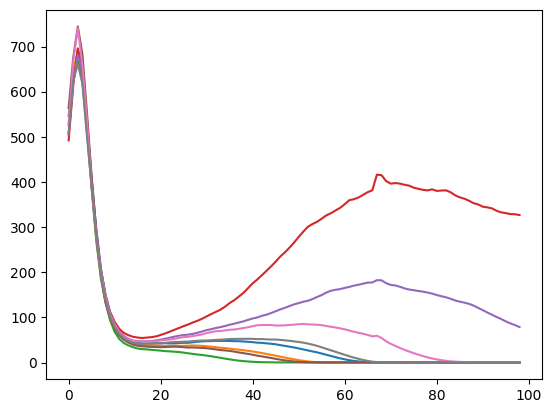

In [7]:
fig, ax = plt.subplots()

for elt in dictionary.history['atoms_evolution']:
    ax.plot(elt)

In [4]:
results, dictionary_sources, dictionary_target = test_odadil([list_of_datasets[0]], n_samples, n_classes, n_atoms, batch_size, n_iter)

1/1
It 1/60, Loss: 6171117.5
It 2/60, Loss: 4110696.4000000004
It 3/60, Loss: 2746697.1999999997
It 4/60, Loss: 1938957.3750000002
It 5/60, Loss: 1642208.2999999998
It 6/60, Loss: 1540006.475
It 7/60, Loss: 1458851.2000000002
It 8/60, Loss: 1425967.825
It 9/60, Loss: 1399149.9500000002
It 10/60, Loss: 1401280.1
It 11/60, Loss: 1354807.975
It 12/60, Loss: 1375101.625
It 13/60, Loss: 1361309.5499999998
It 14/60, Loss: 1353557.4000000001
It 15/60, Loss: 1337773.9249999998
It 16/60, Loss: 1315065.425
It 17/60, Loss: 1310179.575
It 18/60, Loss: 1320909.9000000001
It 19/60, Loss: 1308553.4249999998
It 20/60, Loss: 1297485.2000000002
It 21/60, Loss: 1292778.2249999999
It 22/60, Loss: 1277751.925
It 23/60, Loss: 1269366.0999999999
It 24/60, Loss: 1267517.8
It 25/60, Loss: 1254487.7
It 26/60, Loss: 1245861.3
It 27/60, Loss: 1249724.125
It 28/60, Loss: 1236643.675
It 29/60, Loss: 1214220.275
It 30/60, Loss: 1231212.95
It 31/60, Loss: 1229223.55
It 32/60, Loss: 1215915.325
It 33/60, Loss: 1215241

In [5]:
results

{'lin': {'wda': (0.43, 0.0),
  'e': (0.865, 0.0),
  'e_ot': (0.6054999999999999, 0.0),
  'r': (0.86, 0.0),
  'r_ot': (0.43499999999999994, 0.0)},
 'rbf': {'wda': (0.62, 0.0),
  'e': (0.475, 0.0),
  'e_ot': (0.6044999999999999, 0.0),
  'r': (0.44, 0.0),
  'r_ot': (0.6100000000000001, 0.0)}}

In [6]:
dictionary_target.history['OGMM_evolution']

[21.30610466003418,
 20.95965003967285,
 20.472558975219727,
 19.655601501464844,
 17.955368041992188,
 17.276485443115234,
 19.8266544342041,
 17.57830047607422,
 18.24883270263672,
 16.42501449584961,
 16.486024856567383,
 17.05605697631836,
 15.904091835021973,
 16.85672378540039,
 15.625350952148438,
 16.082534790039062,
 16.563297271728516,
 15.110075950622559,
 15.862828254699707,
 15.049817085266113,
 15.111824035644531,
 15.575752258300781,
 nan,
 13.106024742126465,
 16.227853775024414,
 15.391962051391602,
 13.201647758483887,
 13.702832221984863,
 12.150949478149414,
 11.175985336303711,
 13.432455062866211,
 13.538844108581543,
 11.484346389770508,
 17.991039276123047,
 11.842775344848633,
 11.823822021484375,
 9.544947624206543,
 12.894455909729004]

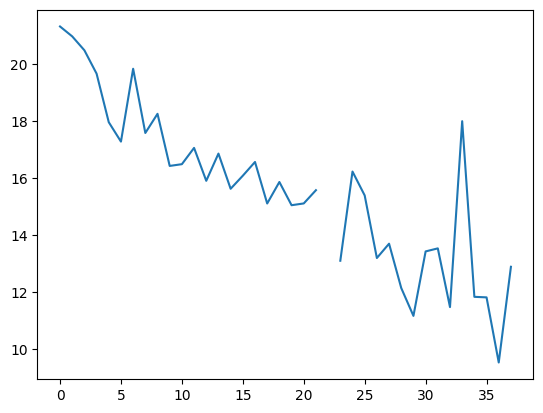

In [7]:
fig, ax = plt.subplots()

ax.plot(dictionary_target.history['OGMM_evolution'])

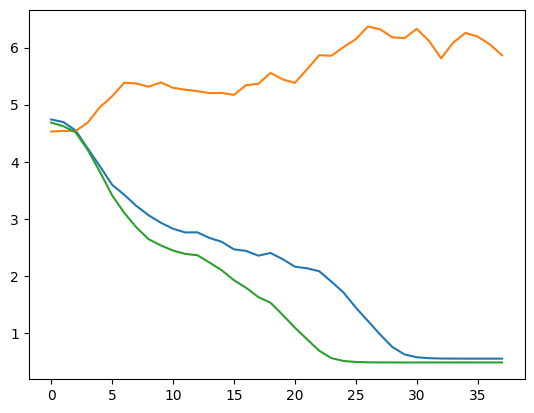

In [8]:
fig, ax = plt.subplots()


for elt in dictionary_target.history['atoms_evolution']:
    ax.plot(elt)

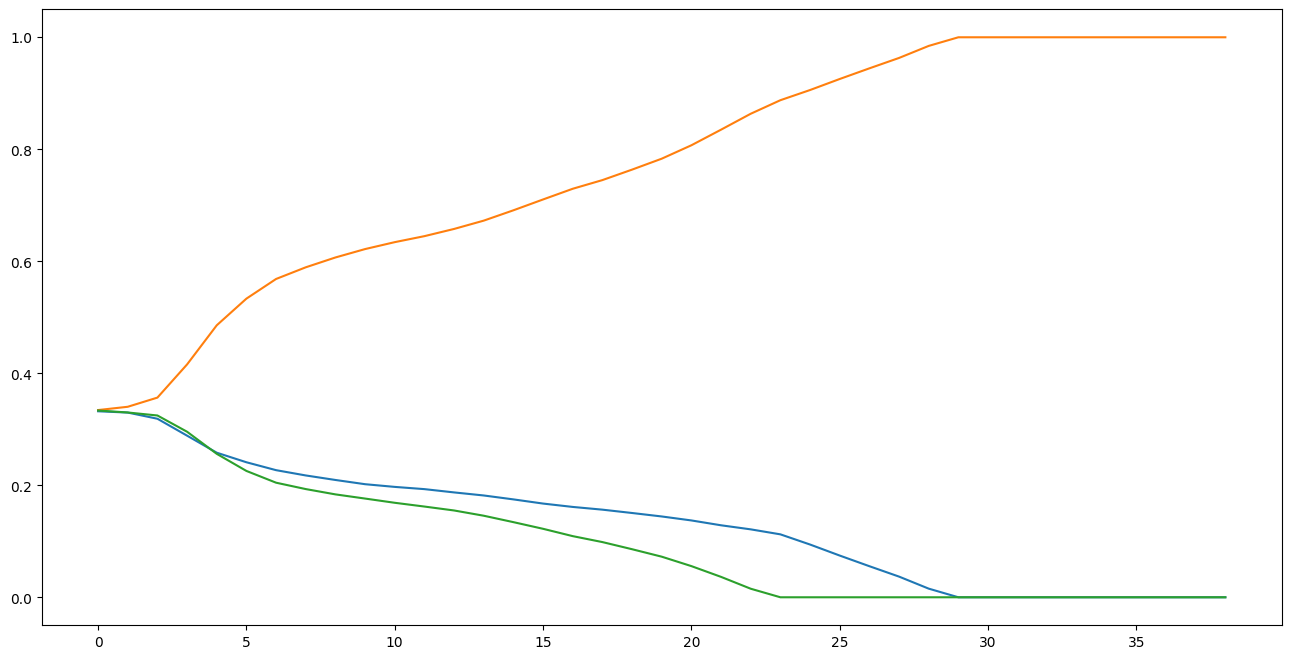

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharey=True)

for k in range(torch.stack(dictionary_target.history['weights']).shape[2]):
    ax.plot(torch.stack(dictionary_target.history['weights'])[:, :, k])

In [5]:
before_online_results, after_online_results = test_forgetting_odadil([list_of_datasets[0]], n_samples, n_classes, n_atoms, batch_size, n_iter)

1/1
It 1/60, Loss: 5795828.0
It 2/60, Loss: 3776803.5999999996
It 3/60, Loss: 2156092.5
It 4/60, Loss: 1470445.1999999997
It 5/60, Loss: 1195241.7249999999
It 6/60, Loss: 1073723.825
It 7/60, Loss: 1000173.0
It 8/60, Loss: 992671.5625000001
It 9/60, Loss: 972160.4499999998
It 10/60, Loss: 986654.7625
It 11/60, Loss: 960452.8375000001
It 12/60, Loss: 935509.15
It 13/60, Loss: 938415.15
It 14/60, Loss: 950937.7125
It 15/60, Loss: 917562.375
It 16/60, Loss: 916256.9375
It 17/60, Loss: 910223.4375
It 18/60, Loss: 924201.0
It 19/60, Loss: 919480.2124999999
It 20/60, Loss: 902989.15
It 21/60, Loss: 903938.4125
It 22/60, Loss: 888345.7249999999
It 23/60, Loss: 856211.5875000001
It 24/60, Loss: 864724.4375
It 25/60, Loss: 869098.5375000001
It 26/60, Loss: 868478.4875
It 27/60, Loss: 848205.1625
It 28/60, Loss: 846777.9624999999
It 29/60, Loss: 857143.775
It 30/60, Loss: 838949.9
It 31/60, Loss: 837453.975
It 32/60, Loss: 832246.5
It 33/60, Loss: 813890.2
It 34/60, Loss: 835402.8
It 35/60, Loss

In [6]:
before_online_results

{'lin': {'r': [1.0, 0.617, 0.955, 0.919, 0.683],
  'r_ot': [0.5730000000000001,
   0.5620000000000002,
   0.5519999999999999,
   0.5570000000000002,
   0.5519999999999999]},
 'rbf': {'r': [0.369, 0.416, 0.519, 0.707, 0.613],
  'r_ot': [0.8539999999999999,
   0.6509999999999999,
   0.8100000000000003,
   0.598,
   0.798]}}

In [7]:
after_online_results

{'lin': {'r': [1.0, 0.62, 0.829, 0.981, 0.838],
  'r_ot': [0.5620000000000002,
   0.5490000000000002,
   0.5549999999999999,
   0.556,
   0.574]},
 'rbf': {'r': [0.363, 0.472, 0.515, 0.753, 0.644],
  'r_ot': [0.8619999999999999,
   0.684,
   0.885,
   0.7729999999999999,
   0.8110000000000002]}}

In [8]:
c = 0
m = 0
for kc in before_online_results.keys():
    for kd in before_online_results[kc].keys():
        for i in range(len(before_online_results[kc][kd])):
            c += 1
            m += after_online_results[kc][kd][i]/before_online_results[kc][kd][i]
m/c

1.0428181201470679

# CWRU

In [14]:
target = 'C'
with open(os.path.join('data', 'mlp_fts_256_target_{}.pkl'.format(target)), 'rb') as f:
        dataset = pickle.loads(f.read())

Xs, ys = [], []
d = None
keys = list(dataset.keys())
for i in [0, 1]:
    features = dataset[keys[i]]['Features']
    labels = dataset[keys[i]]['Labels'].argmax(dim=1)
    domain = i*np.ones((features.shape[0], 1))
    Xs.append(features.float())
    ys.append(labels.float())
    if d is None:
        d = domain
    else:
        d = np.concatenate([d, domain], axis=0)

Xt = dataset[target]['fold 0']['Train']['Features'].float()
yt = dataset[target]['fold 0']['Train']['Labels'].float().argmax(dim=1)

Xt_test = dataset[target]['fold 0']['Test']['Features'].float()
yt_test = dataset[target]['fold 0']['Test']['Labels'].float().argmax(dim=1)
d = np.concatenate([d, 2*np.ones((Xt.shape[0], 1))], axis=0)

n_domains = int(np.max(d)) + 1
n_features = Xt.shape[1]
n_classes = int(np.max(yt.numpy())) + 1

In [22]:
results = test_dadil(Xs, ys, Xt, yt, Xt_test, yt_test, n_features, n_samples, n_classes, n_atoms, batch_size, n_iter)

It 1/100, Loss: 7410.03173828125
It 2/100, Loss: 5434.06708984375
It 3/100, Loss: 3959.6238281250003
It 4/100, Loss: 3018.6269531250005
It 5/100, Loss: 2338.546142578125
It 6/100, Loss: 1850.917724609375
It 7/100, Loss: 1472.7577880859374
It 8/100, Loss: 1172.9741455078126
It 9/100, Loss: 951.0959228515626
It 10/100, Loss: 774.662841796875
It 11/100, Loss: 645.2108642578124
It 12/100, Loss: 549.780419921875
It 13/100, Loss: 479.5917114257812
It 14/100, Loss: 420.4764526367187
It 15/100, Loss: 388.74168090820314
It 16/100, Loss: 339.52911987304685
It 17/100, Loss: 316.65272216796876
It 18/100, Loss: 288.9431945800781
It 19/100, Loss: 259.4006652832031
It 20/100, Loss: 261.90569763183595
It 21/100, Loss: 246.58533935546876
It 22/100, Loss: 225.20755920410159
It 23/100, Loss: 206.54473266601562
It 24/100, Loss: 207.5506866455078
It 25/100, Loss: 175.09521484375003
It 26/100, Loss: 163.00850524902341
It 27/100, Loss: 138.21900482177733
It 28/100, Loss: 113.83731994628907
It 29/100, Loss: 1

In [24]:
results

{'lin': {'wda': 0.7745833333333333,
  'e': 0.31083333333333335,
  'e_ot': 0.8665416666666668,
  'r': 0.8729166666666667,
  'r_ot': 0.9245833333333333},
 'rbf': {'wda': 0.78875,
  'e': 0.70875,
  'e_ot': 0.983875,
  'r': 0.9991666666666666,
  'r_ot': 0.9991666666666668},
 'RF': {'wda': 0.78,
  'e': 0.5916666666666667,
  'e_ot': 0.8619166666666667,
  'r': 0.9370833333333334,
  'r_ot': 0.8642916666666667}}

In [18]:
results, dictionary_sources, dictionary_target = test_odadil(Xs, ys, Xt, yt, Xt_test, yt_test, n_features, n_samples, n_classes, n_atoms, batch_size, n_iter)

It 1/60, Loss: 6004.112988281249
It 2/60, Loss: 4570.87412109375
It 3/60, Loss: 3347.0327148437505
It 4/60, Loss: 2478.021484375
It 5/60, Loss: 1896.1646240234377
It 6/60, Loss: 1502.892724609375
It 7/60, Loss: 1204.091796875
It 8/60, Loss: 977.4310302734375
It 9/60, Loss: 789.9084106445312
It 10/60, Loss: 646.8569458007813
It 11/60, Loss: 529.7445251464844
It 12/60, Loss: 432.49916381835936
It 13/60, Loss: 354.6323364257812
It 14/60, Loss: 295.6015930175781
It 15/60, Loss: 244.79593811035159
It 16/60, Loss: 206.84077453613278
It 17/60, Loss: 173.75559082031248
It 18/60, Loss: 146.54774475097656
It 19/60, Loss: 125.88399200439454
It 20/60, Loss: 110.19701690673828
It 21/60, Loss: 95.34882202148438
It 22/60, Loss: 83.60518035888671
It 23/60, Loss: 73.9080307006836
It 24/60, Loss: 65.90294570922852
It 25/60, Loss: 59.52656631469726
It 26/60, Loss: 54.38151931762695
It 27/60, Loss: 50.456430053710946
It 28/60, Loss: 45.72384872436524
It 29/60, Loss: 42.52431030273438
It 30/60, Loss: 39.67

In [19]:
results

{'lin': {'wda': 0.7316666666666667,
  'e': 0.47208333333333335,
  'e_ot': 0.9374166666666666,
  'r': 0.9966666666666667,
  'r_ot': 0.9370833333333335},
 'rbf': {'wda': 0.72125,
  'e': 0.6091666666666666,
  'e_ot': 0.9736666666666667,
  'r': 0.96125,
  'r_ot': 0.9604166666666669}}

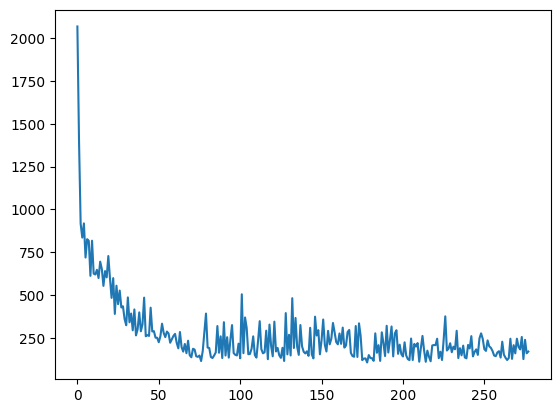

In [20]:
fig, ax = plt.subplots()

ax.plot(dictionary_target.history['OGMM_evolution'])

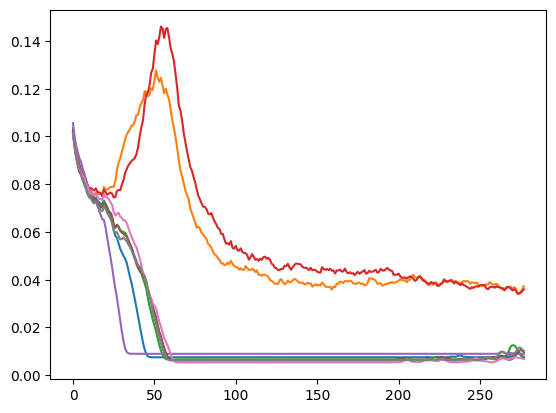

In [21]:
fig, ax = plt.subplots()


for elt in dictionary_target.history['atoms_evolution']:
    ax.plot(elt)

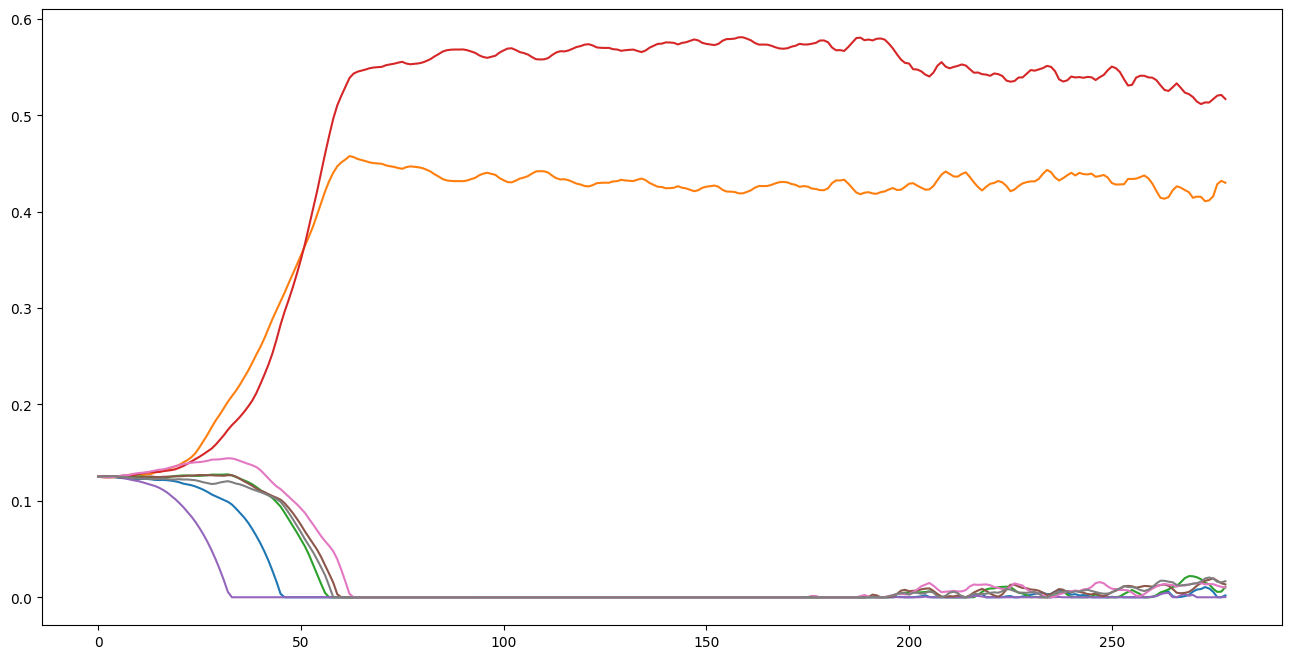

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8), sharey=True)

for k in range(torch.stack(dictionary_target.history['weights']).shape[2]):
    ax.plot(torch.stack(dictionary_target.history['weights'])[:, :, k])

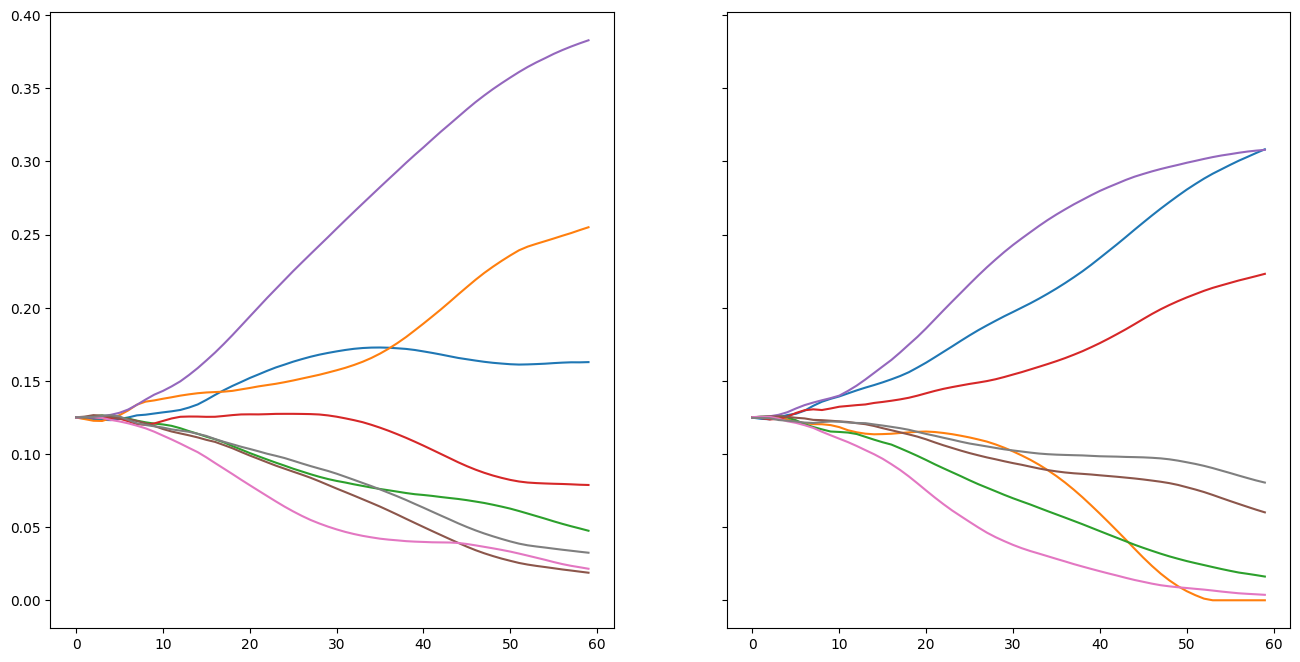

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

for k, ax in enumerate(axes.flatten()):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])

In [12]:
before_online_results, after_online_results = test_forgetting_odadil(Xs, ys, Xt, yt, Xt_test, yt_test, n_features, n_samples, n_classes, n_atoms, batch_size, n_iter)

It 1/60, Loss: 6220.516503906249
It 2/60, Loss: 4635.4931640625
It 3/60, Loss: 3402.7239746093755
It 4/60, Loss: 2617.25263671875
It 5/60, Loss: 2036.61962890625
It 6/60, Loss: 1648.9149658203123
It 7/60, Loss: 1341.7871582031248
It 8/60, Loss: 1080.5602783203126
It 9/60, Loss: 884.4685546875
It 10/60, Loss: 721.471875
It 11/60, Loss: 600.290576171875
It 12/60, Loss: 483.71588745117185
It 13/60, Loss: 402.7222290039062
It 14/60, Loss: 335.7618713378906
It 15/60, Loss: 277.3328125
It 16/60, Loss: 233.58473205566403
It 17/60, Loss: 195.9217559814453
It 18/60, Loss: 165.18516235351564
It 19/60, Loss: 141.26181030273438
It 20/60, Loss: 122.64079742431642
It 21/60, Loss: 108.25721130371093
It 22/60, Loss: 93.06063079833984
It 23/60, Loss: 82.54921112060546
It 24/60, Loss: 73.4244888305664
It 25/60, Loss: 65.18063888549806
It 26/60, Loss: 59.70128936767578
It 27/60, Loss: 53.535308837890625
It 28/60, Loss: 48.61254043579102
It 29/60, Loss: 44.812306976318354
It 30/60, Loss: 41.49555969238280

In [13]:
before_online_results

{'lin': {'r': [1.0, 1.0], 'r_ot': [0.9966250000000001, 0.9971250000000003]},
 'rbf': {'r': [1.0, 1.0], 'r_ot': [1.0, 1.0]}}

In [14]:
after_online_results

{'lin': {'r': [1.0, 1.0], 'r_ot': [0.99825, 0.9967500000000002]},
 'rbf': {'r': [1.0, 1.0], 'r_ot': [1.0, 1.0]}}

In [15]:
c = 0
m = 0
for kc in before_online_results.keys():
    for kd in before_online_results[kc].keys():
        for i in range(len(before_online_results[kc][kd])):
            c += 1
            m += after_online_results[kc][kd][i]/before_online_results[kc][kd][i]
m/c

1.0001568027142378